In [1]:
# wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=14UBHX6GTW_4YiyjNJB3EEq7Xb83AjuaK' -O process_mining_datasets.zip

import pandas as pd
# pd.set_option("max_columns", 200)
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Meus pacotes
# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc
from source import online_streaming_clustering as on_sc

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, ndcg_score, dcg_score, roc_curve, average_precision_score

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 
from scipy.optimize import linear_sum_assignment
import traceback 

from copy import deepcopy
import random
random.seed(42)
import os
import re
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial import distance
import glob

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.metrics.cluster import contingency_matrix
import munkres

import gc
gc.enable()

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    https://stackoverflow.com/questions/50589770/ast-literal-eval-malformed-node-or-string-while-converting-a-string-with-list
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

In [6]:
binary_support = ["cb", "cf",  "cm", "rp", "pm", "fr", 're']
frequency_support = binary_support + ['lp', 'cp', ]
transitions_support = frequency_support + ["pl", "cd", "sw"]
composite = ['RIO', 'ROI', 'ORI', 'OIR', 'IRO', 'IOR']

In [334]:
respostas = {
    'cb': ["I", "H"],
    'cd': ["D", "G"],
    'cf': ["M", "N"],
    'cm': ["I"], # descoberto 'na mão'
    'cp': ["D", "G"],
    # 'fr': ["A", "D", "G"],
    'fr': ['M', 'N'],
    'lp': ["A", "C", "D", "G"],
    'pl': ["A", "D", "G"],
    'pm': ["I"],
    're': ["C"],
    'rp': ["O", "Replaced_Activity"], # + Replaced Activity 
    'sw': ["O", "I", "H"],
    'IOR': ["K"], # + Added Activity
    'IRO': ["O", "I"], # + Added Activity
    'OIR': ["D", "G", "A"], # + Added Activity
    'ORI': ["H", "N", "M", "O"], # + Added Activity
    'RIO': ["N", "I", "H", "M"],
    'ROI': ["A", "G"]
}

transitions_requirement = {
    'cb': ["C I", "C N", "C M", 'I H', 'H N', 'H M'],
    'cd': ['G D', 'A C'],
    'cf': ['H N', 'H M', 'M N', 'M O'],
    'cm': ['C H', 'C I', "I H"],
    'cp': ['O G', 'O E', 'O B'],
    # 'fr': ['F G', 'G D', 'F A', 'A C', 'D C'],
    'fr': ['H M', 'H N', 'M O', 'N O'],
    'lp': ['C G', 'C A', 'G D', 'D C', 'A C'],
    'pl': ['F A', 'A G', 'G D', 'D C', 'A D'],
    'pm': ['C I', 'C H', 'I F', 'I N', 'N I', 'N O', 'I O', 'H I'],
    're': ['D C', 'A C', 'D I', 'D K', 'A I', "A K"],
    'rp': ['N O', 'M O', 'O E', 'O B', 'N Replaced_Activity', 'M Replaced_Activity', 'Replaced_Activity E', 'Replaced_Activity B'],
    'sw': ['C O', 'C I', 'O N', 'O M', 'M I', 'N I', 'H E', 'H B', 'H N', 'H M'] 
}

### Plot Visualizations

In [29]:
combinations = list(
    ParameterGrid({
        'tipo_mudanca': ['cp'],
        'log_size': [5000],
        'representation': ['frequency'],
        'window_size': [100],
        'model': ['kmeans__k=2'],
        'sliding_window': [False]
    })
)
 
c = combinations[0]

df = pd.read_csv(base_dir + c["tipo_mudanca"] + "/" + opts_to_string(combinations[0]) + ".csv", index_col=0)
df.centroids = df.centroids.apply(string_to_numpy)
df.index += df.index[1]

In [30]:
v = []
previous = df.centroids.iloc[0]
for i in range(1, len(df.centroids)):
    v.append(
        localize_drift(previous, df.centroids.iloc[i], cached_resp["_".join([c["tipo_mudanca"], str(c["log_size"]), c["representation"]])][0]).to_dict()[0]
    )
    previous = df.centroids.iloc[i]

In [31]:
df_plot = pd.DataFrame(v)
df_plot.index = df.index[1:]

In [32]:
df_plot.loc[c['window_size']] = 0
df_plot.loc[0] = 0
df_plot = df_plot.sort_index()

In [33]:
def reinverse_transitions(df):
    new_cols = []
    for col in df.columns:
        a, b = col.split(" ")
        new_cols.append(
            inv_aliases[a] + " -> " + inv_aliases[b]
        )
    df.columns = new_cols

In [34]:
if c["representation"] == 'transitions':
    reinverse_transitions(df_plot)

In [35]:
df_plot

,A,B,C,D,E,END_A,END_C,END_R,F,G,H,I,J,K,L,M,N,O,START
i,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
100,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
200,0.0,0.000058,0.0,0.0,0.000058,0.000058,0.000058,0.0,0.003194,0.0,0.0,0.0,0.003194,0.0,0.003194,0.012151,0.012151,0.0,0.0
300,0.0,0.005253,0.0,0.0,0.005253,0.005253,0.005253,0.0,0.014333,0.0,0.0,0.0,0.014333,0.0,0.014333,0.010392,0.010392,0.0,0.0
400,0.0,0.002689,0.0,0.0,0.002689,0.002689,0.002689,0.0,0.010000,0.0,0.0,0.0,0.010000,0.0,0.010000,0.004565,0.004565,0.0,0.0
500,0.0,0.001467,0.0,0.0,0.001467,0.001467,0.001467,0.0,0.014672,0.0,0.0,0.0,0.014672,0.0,0.014672,0.024691,0.024691,0.0,0.0
600,0.0,0.002620,0.0,0.5,0.002620,0.002620,0.002620,0.0,0.004850,0.5,0.0,0.0,0.004850,0.0,0.004850,0.001596,0.001596,0.0,0.0
700,0.0,0.000786,0.0,0.0,0.000786,0.000786,0.000786,0.0,0.004297,0.0,0.0,0.0,0.004297,0.0,0.004297,0.006069,0.006069,0.0,0.0
800,0.0,0.002061,0.0,0.0,0.002061,0.002061,0.002061,0.0,0.005445,0.0,0.0,0.0,0.005445,0.0,0.005445,0.001415,0.001415,0.0,0.0


In [36]:
list(range(int(c["log_size"]/10), c["log_size"], int(c["log_size"]/10)))

[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]

Text(0.5, 0, 'MSE')

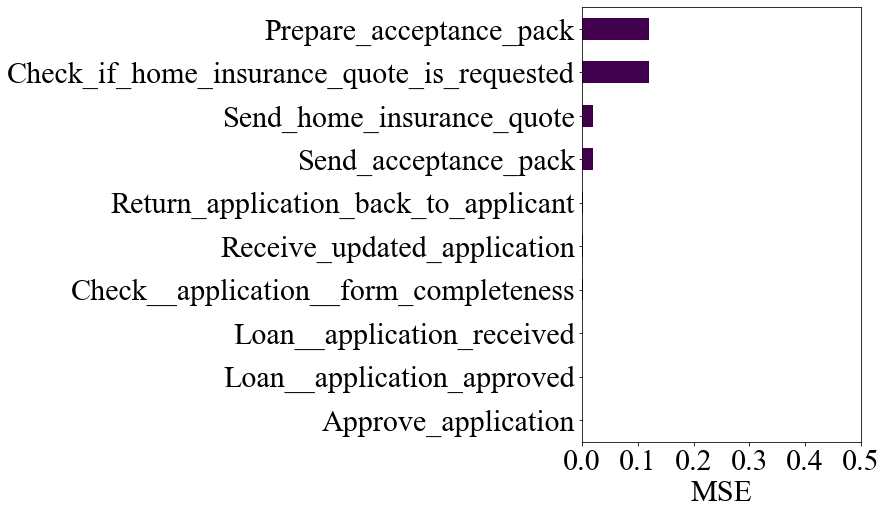

In [189]:
mses = df_plot.rename(columns=inv_aliases).loc[875].sort_values(ascending=True)
mses.tail(10).plot.barh(figsize=(5,8), colormap='PRGn')

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

ax.set_xlim((0, 0.5))
ax.set_xlabel('MSE')

Text(0.5, 0, 'MSE')

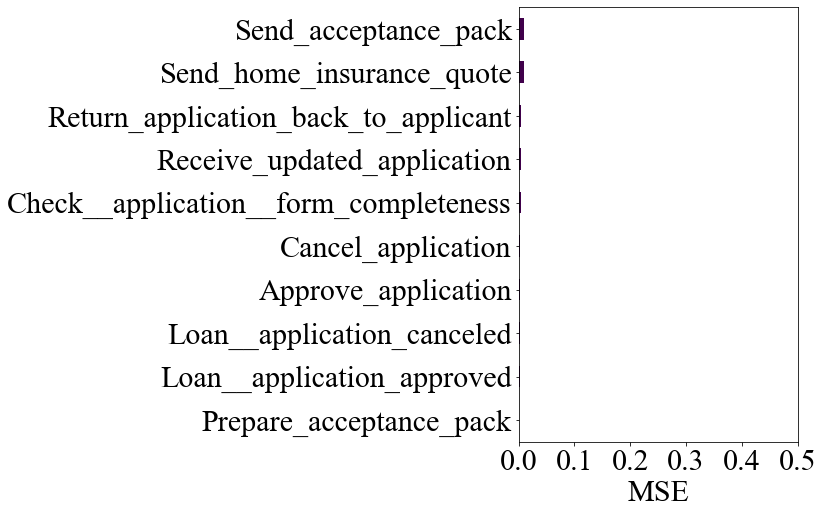

In [184]:
mses = df_plot.rename(columns=inv_aliases).loc[7125].sort_values(ascending=True)
mses.tail(10).plot.barh(figsize=(5,8), colormap="PRGn")

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

ax.set_xlim((0, 0.5))
ax.set_xlabel('MSE')

In [81]:
inv_aliases["A"]

'Appraise_property'

In [40]:
inv_aliases

{'START': 'Loan__application_received',
 'A': 'Appraise_property',
 'B': 'Approve_application',
 'C': 'Assess_eligibility',
 'D': 'Assess_loan_risk',
 'E': 'Cancel_application',
 'F': 'Check__application__form_completeness',
 'G': 'Check_credit_history',
 'H': 'Check_if_home_insurance_quote_is_requested',
 'I': 'Prepare_acceptance_pack',
 'J': 'Receive_updated_application',
 'K': 'Reject_application',
 'L': 'Return_application_back_to_applicant',
 'M': 'Send_acceptance_pack',
 'N': 'Send_home_insurance_quote',
 'O': 'Verify_repayment_agreement',
 'END_A': 'Loan__application_approved',
 'END_R': 'Loan_application_rejected',
 'END_C': 'Loan__application_canceled'}

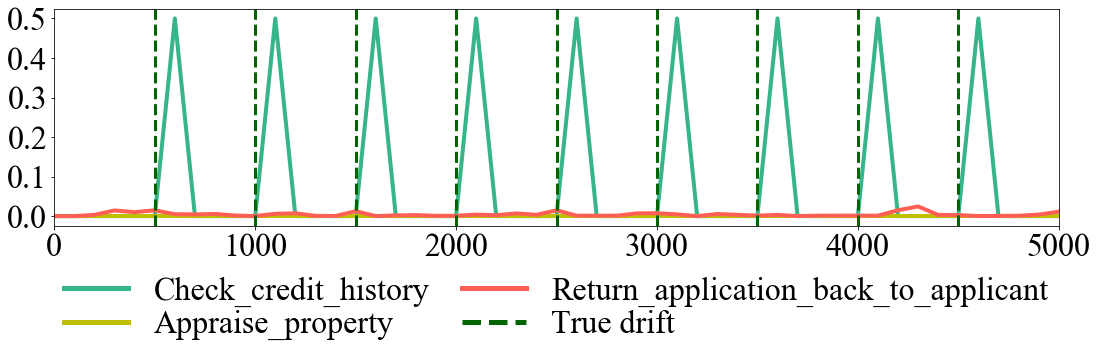

In [63]:
df_plot[["G", "A", "L"]].rename(columns=inv_aliases).plot(figsize=(18,4), lw=4, color = ['#35b588', 'y', '#ff5f54'])
plts.plot_drift_vertical_lines(c['log_size'], label="True drift")

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(32)

# ax.set_xlabel('índice dos $\it{traces}$')
ax.set_xlabel(None)
# ax.set_xlim((0, df.index.max() + 100))
# bbox_to_anchor=(0.5, 1.3),
leg = plt.legend(fontsize=32, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, prop={"family":"Times New Roman", "size":"32"},
          frameon=False, ncol=2, labelspacing=0.1, columnspacing=1)

for line in leg.get_lines():
    line.set_linewidth(5)

In [249]:
resp_df[
    (resp_df.tipo_mudanca == "cb") &
    (resp_df.representation == 'binary') &
    (resp_df.model == "kmeans__k=2") &
    (resp_df.window_size == 250) & 
    (resp_df.log_size == 5000)
]

,log_size,model,representation,sliding_window,tipo_mudanca,window_size,y_true,localizations,roc_scores,avg_precisions,AVG_roc_scores,AVG_avg_precisions,flag_binary_support,flag_frequency_support
1241,5000,kmeans__k=2,binary,False,cb,250,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[{'H': 0.15849869354777202, 'I': 0.15849869354...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.0,1.0,True,True


## Running Localization Experiments 

In [3]:
aliases = {
    'Loan__application_received': 'START',
    'Appraise_property': 'A',
    'Approve_application': 'B',
    'Assess_eligibility': 'C',
    'Assess_loan_risk': 'D',
    'Cancel_application': 'E',
    'Check__application__form_completeness': 'F',
    'Check_credit_history': 'G',
    'Check_if_home_insurance_quote_is_requested': 'H',
    'Prepare_acceptance_pack': 'I',
    'Receive_updated_application': 'J',
    'Reject_application': 'K',
    'Return_application_back_to_applicant': 'L',
    'Send_acceptance_pack': 'M',
    'Send_home_insurance_quote': 'N',
    'Verify_repayment_agreement': 'O',
    'Loan__application_approved': 'END_A',
    'Loan_application_rejected': 'END_R',
    'Loan__application_canceled': 'END_C',
}

respostas = {
    'cb': ["I", "H"],
    'cd': ["D", "G"],
    'cf': ["M", "N"],
    'cm': ["I"], # descoberto 'na mão'
    'cp': ["D", "G"],
    # 'fr': ["A", "D", "G"],
    'fr': ['M', 'N'],
    'lp': ["A", "C", "D", "G"],
    'pl': ["A", "D", "G"],
    'pm': ["I"],
    're': ["C"],
    'rp': ["O", "Replaced_Activity"], # + Replaced Activity 
    'sw': ["O", "I", "H"],
    'IOR': ["K", 'Added_Activity'], # + Added Activity
    'IRO': ["M", "N", "B", "O", "I", "Added_Activity"], # + Added Activity
    'OIR': ["D", "G", "A", 'Added_Activity'], # + Added Activity
    'ORI': ["H", "N", "M", "O", "Added_Activity"], # + Added Activity
    'RIO': ["N", "M", "I", "H"],
    'ROI': ["G", "Replaced_Activity"]
}

transitions_requirement = {
    'cb': ["C I", "C N", "C M", 'I H', 'H N', 'H M'],
    'cd': ['G D', 'A C'],
    'cf': ['H N', 'H M', 'M N', 'M O'],
    'cm': ['C H', 'C I', "I H"],
    'cp': ['O G', 'O E', 'O B'],
    # 'fr': ['F G', 'G D', 'F A', 'A C', 'D C'],
    'fr': ['H M', 'H N', 'M O', 'N O'],
    'lp': ['C G', 'C A', 'G D', 'D C', 'A C'],
    'pl': ['F A', 'A G', 'G D', 'D C', 'A D'],
    'pm': ['C I', 'C H', 'I F', 'I N', 'N I', 'N O', 'I O', 'H I'],
    're': ['D C', 'A C', 'D I', 'D K', 'A I', "A K"],
    'rp': ['N O', 'M O', 'O E', 'O B', 'N Replaced_Activity', 'M Replaced_Activity', 'Replaced_Activity E', 'Replaced_Activity B'],
    'sw': ['C O', 'C I', 'O N', 'O M', 'M I', 'N I', 'H E', 'H B', 'H N', 'H M'],
    'IOR': ["Added_Activity END_R", "Added_Activity K", "C_Added Activity", "C K", "K END_R"],
    'IRO': ["Added_Activity B", "Added_Activity END_A", "B END_A", "B O", "I Added_Activity", "O I"],
    'OIR': ["Added_Activity A", "Added_Activity D", "Added_Activity G", "D C", "D G", "F A", "F D", "F G", "F Added_Activity", "D Added_Activity", "G Added_Activity", "G C", "G D"],
    'ORI': ["Added_Activity M", "N Added_Activity", "H M", "H N", "M O", "N O"],
    'RIO': ["H O", "N I", "N O"],
    'ROI': ["A G", "A Replaced_Activity", "F A", "F G", "Replaced_Activity A", "Replaced_Activity D"],
}

In [10]:
def get_localization_y_true(col_names, cols_resposta):
    y_true_localization = pd.Series(0, index=col_names)
    for act in cols_resposta:
        if act in y_true_localization.index:
            y_true_localization.loc[act] = 1
        
    return y_true_localization.sort_index()


def get_localization_results(args):
    """
        Given the result of a trace clustering experiment, run the localization experiment for all correct drifts
    """
    clustering_results = pd.read_pickle(args["input"], compression='gzip')
    
    path_file = args["input"].replace(".pickle.gzip", "").split('\\')
    
    args.update({
        "tipo_mudanca": path_file[-1].split('_')[0],
        "log_size": int(path_file[-1].split('_')[1]),
        "model": "_".join(path_file[-1].split('_')[2:5]),
        "representation": "_".join(path_file[-1].split('_')[5:-2]),
        "window_size": path_file[-1].split('_')[-2],
        "sliding_window": path_file[-1].split('_')[-1]
    })
    
    log_size = args['log_size']
    cd_name = args['tipo_mudanca']
    win_size = int(args['window_size'])
    y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]
    
    print(args['input'])
    
    resp = []

    centers = clustering_results.centroids
    colnames = clustering_results.iloc[0].colnames.split()
    colnames = [aliases[x] if x in aliases else x for x in colnames]

    if args['representation'] != 'transitions':
        y_true_localization = get_localization_y_true(colnames, respostas[cd_name])
    else:
        if cd_name not in transitions_requirement:
            return
        
        colnames = [" ".join([colnames[i-1], colnames[i]]) for i in range(1, len(colnames), 2)]        
        y_true_localization = get_localization_y_true(colnames, transitions_requirement[cd_name])
        
    
    roc_scores = []
    localizations = []
    for correct_drift in y_true:        
        local = dl.localize_drift(
            centers.iloc[centers.index.get_loc(correct_drift, method="nearest")], 
            centers.iloc[centers.index.get_loc(correct_drift + win_size, method="nearest")],
            colnames
        )

        y_score = local.sort_index().values.reshape(1,-1)[0]
        
        # print(local.sort_index())
        # print(y_true_localization)
        
        try:
            roc_scores.append(
                roc_auc_score(y_true_localization, y_score)
            )
        except ValueError:
            raise
            roc_scores.append(np.nan)

        localizations.append(local)

    args.update({
        'roc_auc_scores': roc_scores,
        'y_score_localizations': y_score,
        'y_true_localizations': y_true_localization
    })
    
    return args

In [11]:
# Example for a specific log

x = pd.DataFrame.from_dict([
    get_localization_results({
        'input': 'EXEC_V2__LoanApplications_Offline\\RIO\\RIO_5000_kmeans__k=2_transitions_100_False.pickle.gzip'
    }),
])
x

C:/Users/rafae/Downloads/EXEC_V2__LoanApplications_Offline\RIO\RIO_5000_kmeans__k=2_transitions_100_False.pickle.gzip


,input,tipo_mudanca,log_size,model,representation,window_size,sliding_window,roc_auc_scores,y_score_localizations,y_true_localizations
0,C:/Users/rafae/Downloads/EXEC_V2__LoanApplicat...,RIO,5000,kmeans__k=2,transitions,100,False,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.009088908022000762, 0.009897155130426716, 0...",A C 0 A D 0 A G 0 B END_A...


#### Running Localization Experiments parallely

In [23]:
clusterings_loan = glob.glob('C:/Users/rafae/Downloads/EXEC_V3__LoanApplications_Offline/*/*.pickle.gzip')

In [24]:
def if_not_any(x, lista):
    for value in lista:
        if value in x:
            return False
    return True

from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm_notebook

In [25]:
combs__ = list(ParameterGrid({
    'input': [x for x in clusterings_loan if if_not_any(x, ['k=4', 'k=5', 'k=6'])],
}))

In [26]:
final_resp = Parallel(n_jobs=3)(
    delayed(get_localization_results)(comb) for comb in tqdm_notebook(combs__)
)

In [27]:
localization_results = pd.DataFrame.from_dict([x for x in final_resp if x is not None])

In [28]:
localization_results.head()

,input,tipo_mudanca,log_size,model,representation,window_size,sliding_window,roc_auc_scores,y_score_localizations,y_true_localizations
0,C:/Users/rafae/Downloads/EXEC_V3__LoanApplicat...,cb,10000,kmeans__k=2,activities_order_normalized,100,False,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0004410018985125783, 0.0009715205405749801,...",A 0 B 0 C 0 D 0 E ...
1,C:/Users/rafae/Downloads/EXEC_V3__LoanApplicat...,cb,10000,kmeans__k=2,activities_order_normalized,125,False,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.00038348804381209964, 0.0003910285678683317...",A 0 B 0 C 0 D 0 E ...
2,C:/Users/rafae/Downloads/EXEC_V3__LoanApplicat...,cb,10000,kmeans__k=2,activities_order_normalized,150,False,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0004835488446773511, 0.0003479566466684391,...",A 0 B 0 C 0 D 0 E ...
3,C:/Users/rafae/Downloads/EXEC_V3__LoanApplicat...,cb,10000,kmeans__k=2,activities_order_normalized,175,False,"[1.0, 1.0, 1.0, 1.0, 0.9666666666666667, 1.0, ...","[3.3245899011210736e-06, 0.004630304437283988,...",A 0 B 0 C 0 D 0 E ...
4,C:/Users/rafae/Downloads/EXEC_V3__LoanApplicat...,cb,10000,kmeans__k=2,activities_order_normalized,200,False,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.00031656049970555625, 0.0008762375958067455...",A 0 B 0 C 0 D 0 E ...


In [29]:
localization_results['AVG__roc_auc_scores'] = localization_results['roc_auc_scores'].apply(np.mean).fillna(0)

final_resp_size = localization_results.groupby([
    'tipo_mudanca', 'model', 'representation', 'window_size'
]).AVG__roc_auc_scores.mean().reset_index()

In [30]:
best_results_localization = final_resp_size.groupby([
    'representation', 'window_size'
]).AVG__roc_auc_scores.mean().sort_values(ascending=False).reset_index().drop_duplicates(subset='representation')

best_results_localization

,representation,window_size,AVG__roc_auc_scores
0,frequency,175,0.982886
5,transitions,125,0.938419
10,binary,125,0.900784
15,activities_order_normalized,125,0.882880


In [31]:
def get_localization_results_by_best_run(results, best_runs, i=0):
    return results[
        (results.window_size == best_runs.iloc[i].window_size) &
        (results.representation == best_runs.iloc[i].representation)
    ]

def get_localization_results_per_rep(results, grouped_means, metric='AVG__roc_auc_scores'):
    g = grouped_means.drop_duplicates(subset=['representation'])
    
    resp = {}
    
    for i in range(len(grouped_means)):
        resp[grouped_means.iloc[i].representation] = get_localization_results_by_best_run(
            results, 
            grouped_means, 
            i
        ).groupby("tipo_mudanca")[metric].mean().sort_index()
        
    return pd.DataFrame(resp)

In [32]:
r = get_localization_results_per_rep(localization_results, best_results_localization, metric='AVG__roc_auc_scores')
r.loc['TOTAL_mean'] = r.mean()
r[['binary', 'frequency', 'transitions', 'activities_order_normalized']].sort_index(ascending=False).loc[
    transitions_support + composite + ['TOTAL_mean']
]

,binary,frequency,transitions,activities_order_normalized
cb,1.000000,1.000000,0.947825,1.000000
cf,1.000000,1.000000,0.979798,1.000000
cm,0.990741,0.990741,0.935556,0.979167
rp,1.000000,1.000000,0.999559,1.000000
pm,1.000000,1.000000,0.915401,1.000000
fr,1.000000,0.992375,0.991182,1.000000
re,1.000000,0.996914,0.990762,1.000000
lp,NaN,0.969136,0.774048,0.726543
cp,NaN,1.000000,0.972840,0.408025
pl,NaN,NaN,0.884352,0.720018


In [393]:
import seaborn as sns

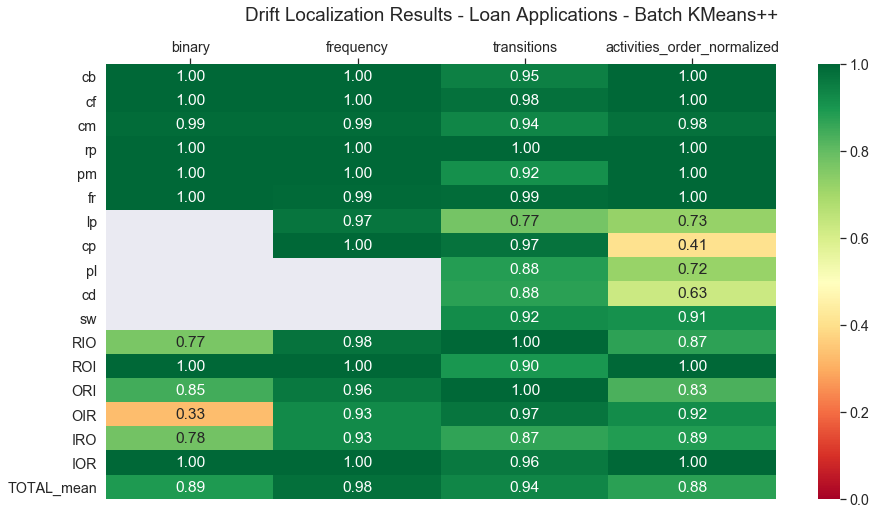

In [402]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(15,8))
ax = sns.heatmap(
    r[['binary', 'frequency', 'transitions', 'activities_order_normalized']].sort_index(ascending=False).loc[
        transitions_support + composite + ['TOTAL_mean']
    ]
    ,annot=True
    ,vmin=0
    ,vmax=1
    ,robust=True
    ,fmt='.2f'
    ,cmap="RdYlGn"
)
ax.xaxis.tick_top()
plt.yticks(rotation=0);
plt.suptitle("Drift Localization Results - Loan Applications - Batch KMeans++");

In [376]:
df_clustered = pd.read_pickle(
    'C:/Users/rafae/Downloads/EXEC_V3__LoanApplications_Offline/ROI/ROI_5000_kmeans__k=3_binary_100_False.pickle.gzip'
    ,compression='gzip'
)

# df_clustered.index += df_clustered.index[1] - 1

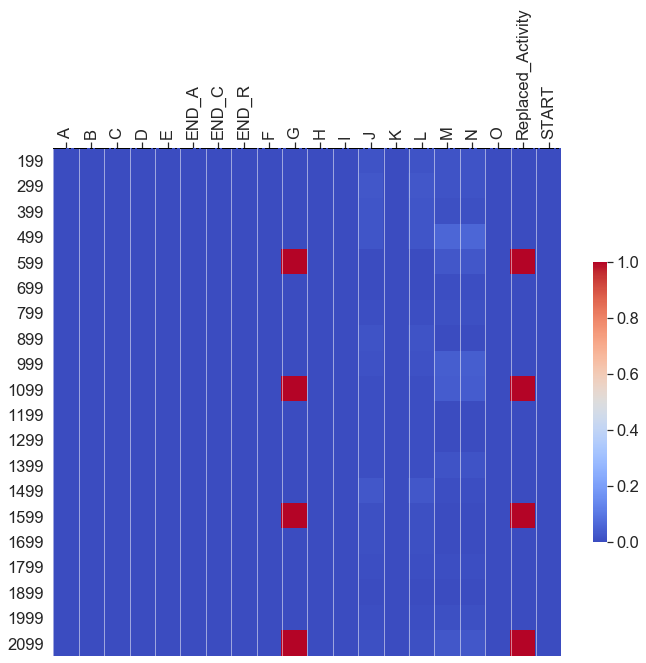

In [377]:
col_names_ = [aliases[x] if x in aliases else x for x in df_clustered.colnames.iloc[0].split()]
if len(col_names_) >= 27:
    col_names_ = [col_names_[i-1] + " " + col_names_[i] for i in range(1, len(col_names_), 2)]
    
# col_names_ = binary_rep.columns

localizations = dl.localize_all_drifts(df_clustered.centroids, df_clustered.index.tolist()[1:], 100, col_names_)
localizations.columns = [int(x.replace('drift_at_', '')) for x in localizations.columns]

plts.plot_drift_localization(localizations.sort_index().transpose().head(20), y_true, figsize=(10, 20))

In [368]:
aliases

{'Loan__application_received': 'START',
 'Appraise_property': 'A',
 'Approve_application': 'B',
 'Assess_eligibility': 'C',
 'Assess_loan_risk': 'D',
 'Cancel_application': 'E',
 'Check__application__form_completeness': 'F',
 'Check_credit_history': 'G',
 'Check_if_home_insurance_quote_is_requested': 'H',
 'Prepare_acceptance_pack': 'I',
 'Receive_updated_application': 'J',
 'Reject_application': 'K',
 'Return_application_back_to_applicant': 'L',
 'Send_acceptance_pack': 'M',
 'Send_home_insurance_quote': 'N',
 'Verify_repayment_agreement': 'O',
 'Loan__application_approved': 'END_A',
 'Loan_application_rejected': 'END_R',
 'Loan__application_canceled': 'END_C'}